In [190]:
import bokeh.plotting as bp
from bokeh.io import show, output_notebook
from bokeh.models import HoverTool
from datashader.bokeh_ext import InteractiveImage
import datashader as ds
import numpy as np
import pandas as pd
import numexpr as ne
import datashader.transfer_functions as tf
from datashader.colors import Greys9, Hot, viridis, inferno, Set1, colormap_select as cm 
from datashader import reductions
from datashader.core import bypixel
from utils import toWebMercator, mega_color
from bokeh.models import HoverTool


In [230]:
file = r'D:\ADSB\working\h5\2017-01-16.h5'
store = pd.HDFStore(file)
points = store.select('data',columns=['Lat','Long','Cou','Mil','Mdl'],
                      where=['Lat>=-90','Lat<=90','Long>=-180','Long<=180']).dropna()
points = points.drop_duplicates()
points['x'],points['y'] = toWebMercator(points['Long'],points['Lat'])

points['Cou'] = points['Cou'].astype('category')
points['Cou'] = points['Cou'].replace([np.inf,-np.inf],np.nan).dropna()

Quick way to get to locations

In [248]:
MaxBounds = ((20048966.10, -20048966.10), (20026376.39, -20026376.39))
DataSetBounds = ((min(points.x),max(points.x)), (min(points.y),max(points.y)))
USA = ((-13884029, -7453304), (2698291, 6455972))
Germany = ((709335.62, 1600000), (6026907, 7270000))
# Chicago = (( -9828281, -9717659), (5096658, 5161298))
# Chinatown = (( -9759210, -9754583), (5137122, 5139825))
# NewYorkCity = (( -8280656, -8175066), (4940514, 4998954))
# LosAngeles = ((-13195052, -13114944), (3979242, 4023720))
# Houston = ((-10692703, -10539441), (3432521, 3517616))
# Austin = ((-10898752, -10855820), (3525750, 3550837))
# NewOrleans = ((-10059963, -10006348), (3480787, 3510555))
Atlanta = (( -9448349, -9354773), (3955797, 4007753))
xrange, yrange = USA

In [274]:
plot_width, plot_height = 900, 500
glyph = ds.glyphs.Point('x', 'y')
canvas = ds.Canvas(plot_width, plot_height, *DataSetBounds)
#agg = bypixel(points, canvas, glyph, reductions.count())
canvas.points(points, 'x', 'y', agg=reductions.count())

<xarray.DataArray (y_axis: 500, x_axis: 900)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * y_axis   (y_axis) float64 -5.333e+06 -5.301e+06 -5.269e+06 -5.237e+06 ...
  * x_axis   (x_axis) float64 -1.43e+07 -1.426e+07 -1.422e+07 -1.418e+07 ...

In [275]:
def bg(img): return tf.set_background(img,"black")

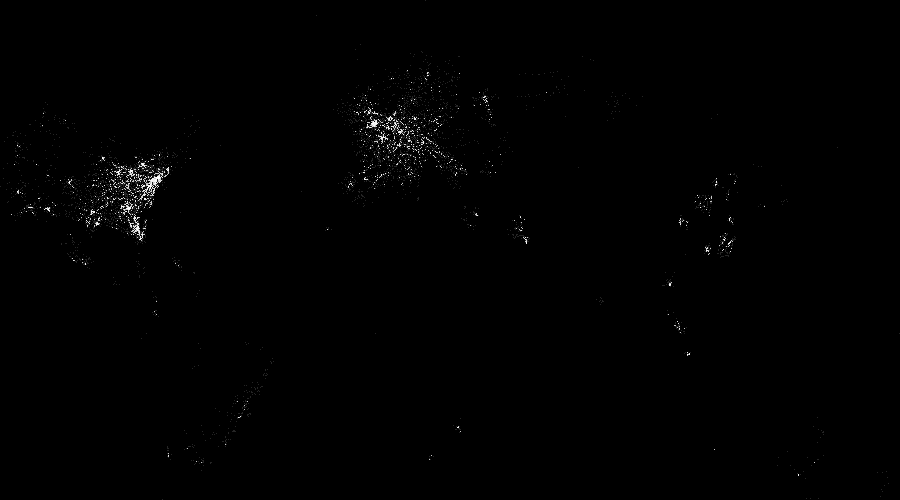

In [276]:
bg(tf.shade(agg, cmap = cm(Greys9,0.2), how='eq_hist'))

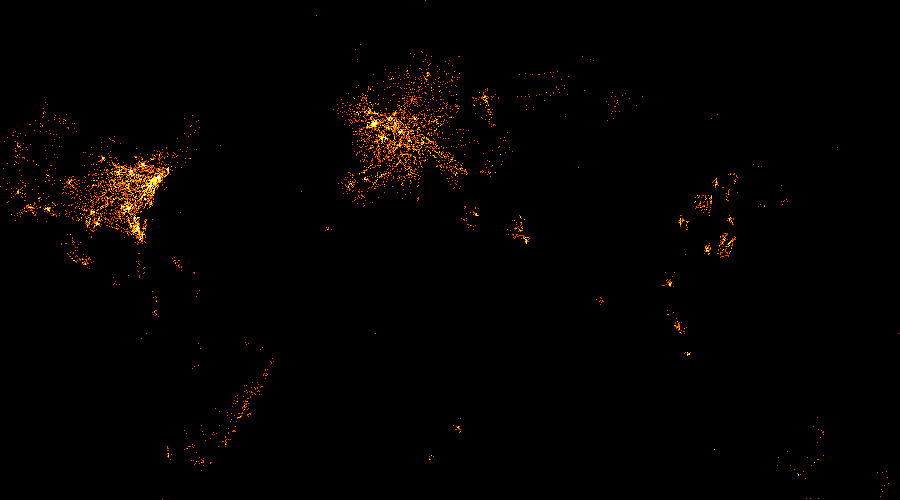

In [277]:
bg(tf.shade(agg, cmap = cm(Hot,0.4)))

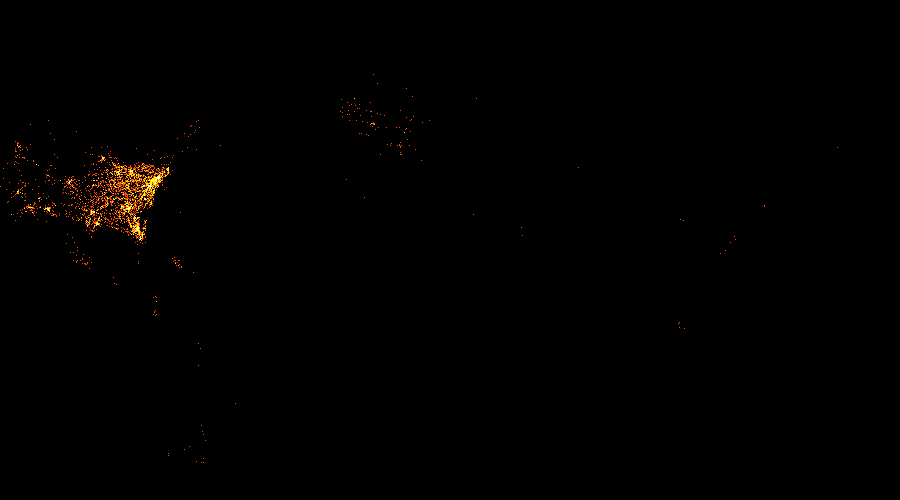

In [278]:
bg(tf.shade(canvas.points(points, 'x', 'y', ds.count_cat('Cou')).sel(Cou='United States'), cm(Hot,0.4)))

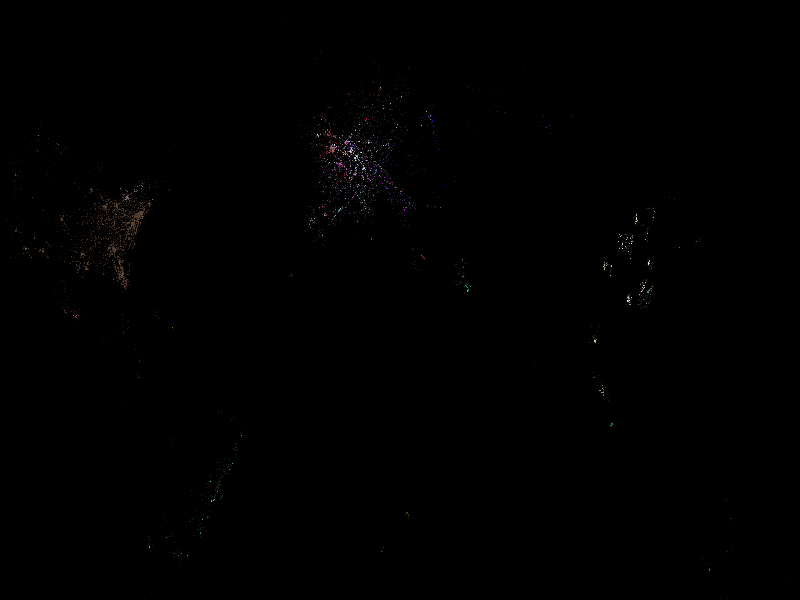

In [284]:
np.seterr(divide='ignore', invalid='ignore')
def create_image(x_range, y_range, w, h, spread=0):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    pts = cvs.points(points, 'x', 'y', ds.count_cat('Cou'))
    img = tf.shade(pts, color_key=mega_color, how='eq_hist')
#     img = tf.shade(pts, cm(Hot,0.4))
    if spread: img = tf.spread(img,px=spread)
    return bg(img)
create_image(*DataSetBounds,800,600)

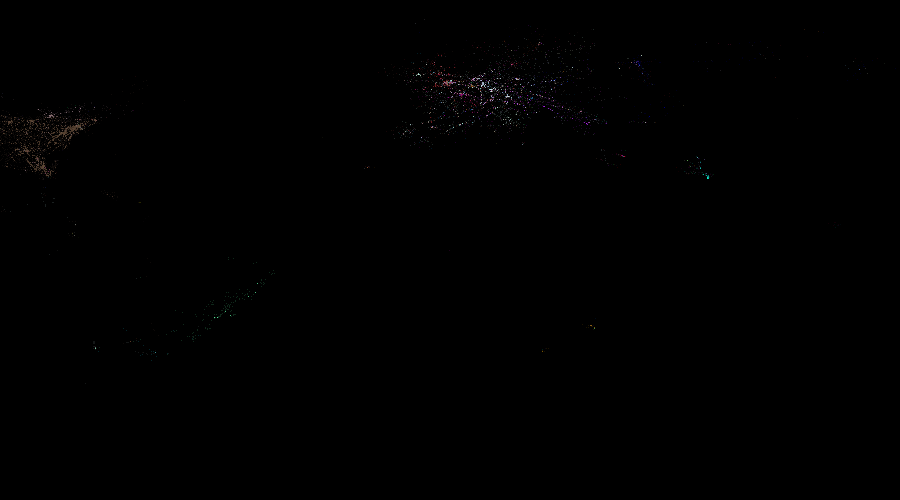

In [285]:
create_image((-10000000,10000000),(-10000000,10000000),900,500)

In [37]:
output_notebook()

Loading BokehJS ...

In [296]:
def base_plot(tools='pan,wheel_zoom,box_zoom,reset',webgl=False,
              xrange=xrange,yrange=yrange,plot_width=int(900),plot_height=int(500),
             bok_cir = True):
    p = bp.figure(tools=tools,
                  plot_width=plot_width, plot_height=plot_height,
                  x_range=xrange, y_range=yrange, outline_line_color=None,
                  min_border=0, min_border_left=0, min_border_right=0,
                  min_border_top=0, min_border_bottom=0, webgl=webgl)
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    if bok_cir:
        p.circle(x=points.x,y=points.y,color='blue', size=2, alpha=0.4) 
    cartocdn = "http://a.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png"
    tile_renderer = p.add_tile(WMTSTileSource(url=cartocdn)) 
    tile_renderer.alpha=0.9
    return p

In [297]:
xr, yr = USA
p = base_plot(xrange=xr,yrange=yr) 

cartocdn = "http://a.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png"
tile_renderer = p.add_tile(WMTSTileSource(url=cartocdn)) 
tile_renderer.alpha=0.9
show(p)

In [ ]:
['Elevation',
 'Greys9',
 'Hot',
 'Set1',
 'Set2',
 'Set3',
 'Sets1to3',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_inferno_data',
 '_mpl_cmdata_to_bokeh_palette',
 '_viridis_data',
 'absolute_import',
 'color_lookup',
 'colormap_select',
 'division',
 'hex_to_rgb',
 'inferno',
 'print_function',
 'rgb',
 'viridis']

In [314]:
np.seterr(divide='ignore', invalid='ignore')
xr, yr = USA
p = base_plot(xrange=xr,yrange=yr,bok_cir=False) 
def image_callback(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    pts = cvs.points(points, 'x', 'y')#, ds.count_cat('Cou'))
    img = tf.shade(pts, cmap=Set1)
    return img
 
InteractiveImage(p, image_callback)

In [315]:
def filter_plot(left_lat,right_lat,bottom_long,top_long,
                plot_width=int(900),plot_height=int(500),webgl=False):
    assert -90 <= left_lat <= right_lat <= 90
    assert -180 <= bottom_long <= top_long <= 180
    filtered = points[(points.Lat>left_lat) & (points.Lat<right_lat) 
                      & (points.Long>bottom_long) & (points.Long<top_long)]
    source = bp.ColumnDataSource(data=filtered)
    p = bp.figure(tools='pan,wheel_zoom,reset,box_zoom,save', 
                  x_range=(filtered.x.min(), filtered.x.max()), 
                  y_range=(filtered.y.min(), filtered.y.max()),
                  plot_width=plot_width, plot_height=plot_height,
                  outline_line_color=None,
                  min_border=0, min_border_left=0, min_border_right=0,
                  min_border_top=0, min_border_bottom=0,webgl=webgl)
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    cartocdn = "http://a.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png"
    tile_renderer = p.add_tile(WMTSTileSource(url=cartocdn)) 
    tile_renderer.alpha=0.9
    print('%i points' % len(filtered))
    return source, p

In [316]:
cities = {'Paris' : (47.856600, 49.856600, 1.352200, 3.352200),
            'Atlanta' : (34.000000, 36.000000, -85.500000, -83.500000,),
            'London' : (50.507400, 52.507400, -1.127800, 0.872200),
            'Moscow' : (36.000000, 38.000000, 54.000000, 56.000000),
            'Munich' : (47.135100, 49.135100, 10.582000, 12.582000),
            'Amsterdam' : (51.370200, 53.370200, 3.895200, 5.895200),
            'Zurich' : (46.376900, 48.376900, 7.541700, 9.541700),
            'Frankfurt' : (49.110900, 51.110900, 7.682100, 9.682100)}

In [317]:
source, p = filter_plot(*cities['Frankfurt']) # Paris
hover = HoverTool()
hover.tooltips = [  
    ('Lat', '@Lat'),
    ('Long', '@Long'),
    ('Country', '@Cou'),
    ('Military', '@Mil'),
    ('AC Model', '@Mdl')
]
p.add_tools(hover)
p.axis.visible = False
tile_renderer = p.add_tile(WMTSTileSource(url=cartocdn)) 
tile_renderer.alpha=0.9
p.scatter('x','y',source=source)
show(p)

84 points


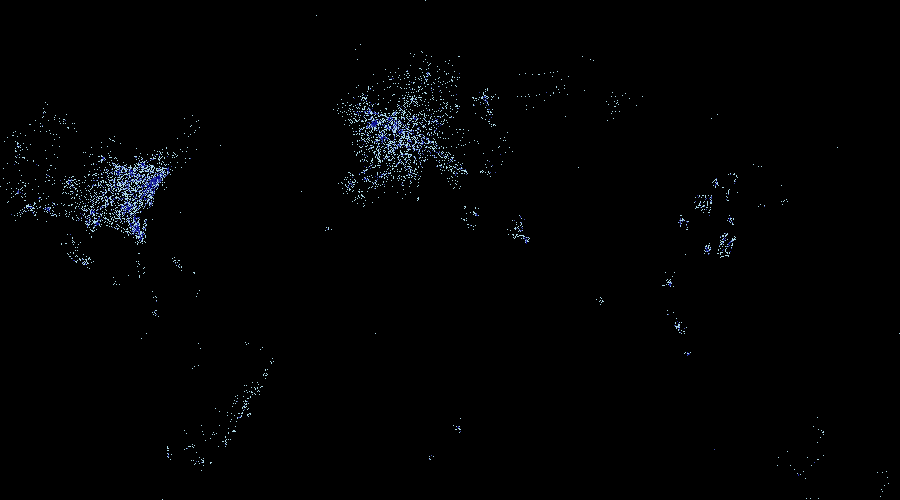

In [320]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

country_list = list(points['Cou'].astype(str).unique())
def my_select_handler(selection):
    tf.shade(canvas.points(points[points['Cou']==selection], 'x', 'y'))
interact(my_select_handler,selection=country_list)
bg(tf.shade(canvas.points(points, 'x', 'y')))